## ARIMA Baseline

Running day-by-day ARIMA prediction with order (1, 1, 1)
Loading data...
Test set contains 7 unique dates.


Processing days: 100%|██████████| 7/7 [00:19<00:00,  2.83s/it]



===== ARIMA Baseline MODEL EVALUATION =====

=== Overall Metrics ===
RMSE: 0.1577
MAE: 0.0644
R²: 0.9665
MAPE: 11.7321%

=== Daily Performance ===
      date     rmse      mae      mape  n_samples
2024-02-09 0.228640 0.058655 14.097859       6581
2024-02-10 0.223899 0.177953 26.870249       6581
2024-02-11 0.254659 0.147447 28.191033       6581
2024-02-12 0.069043 0.021443  4.401785       6581
2024-02-13 0.026612 0.017621  3.265652       6581
2024-02-14 0.025899 0.016596  2.846091       6581
2024-02-15 0.026045 0.011252  2.451703       6581

=== Performance Statistics ===
MAE:
  Average: 0.0644
  Min: 0.0113 (Day: 2024-02-15)
  Max: 0.1780 (Day: 2024-02-10)

RMSE:
  Average: 0.1221
  Min: 0.0259 (Day: 2024-02-14)
  Max: 0.2547 (Day: 2024-02-11)

MAPE:
  Average: 11.73%
  Min: 2.45% (Day: 2024-02-15)
  Max: 28.19% (Day: 2024-02-11)

=== Error Autocorrelation ===
  Lag 1: 0.0075
  Lag 2: 0.0164
  Lag 3: -0.0028
  Lag 4: 0.0101
  Lag 5: 0.0145
  Lag 6: 0.0190
  Lag 7: -0.0047

=== Error 

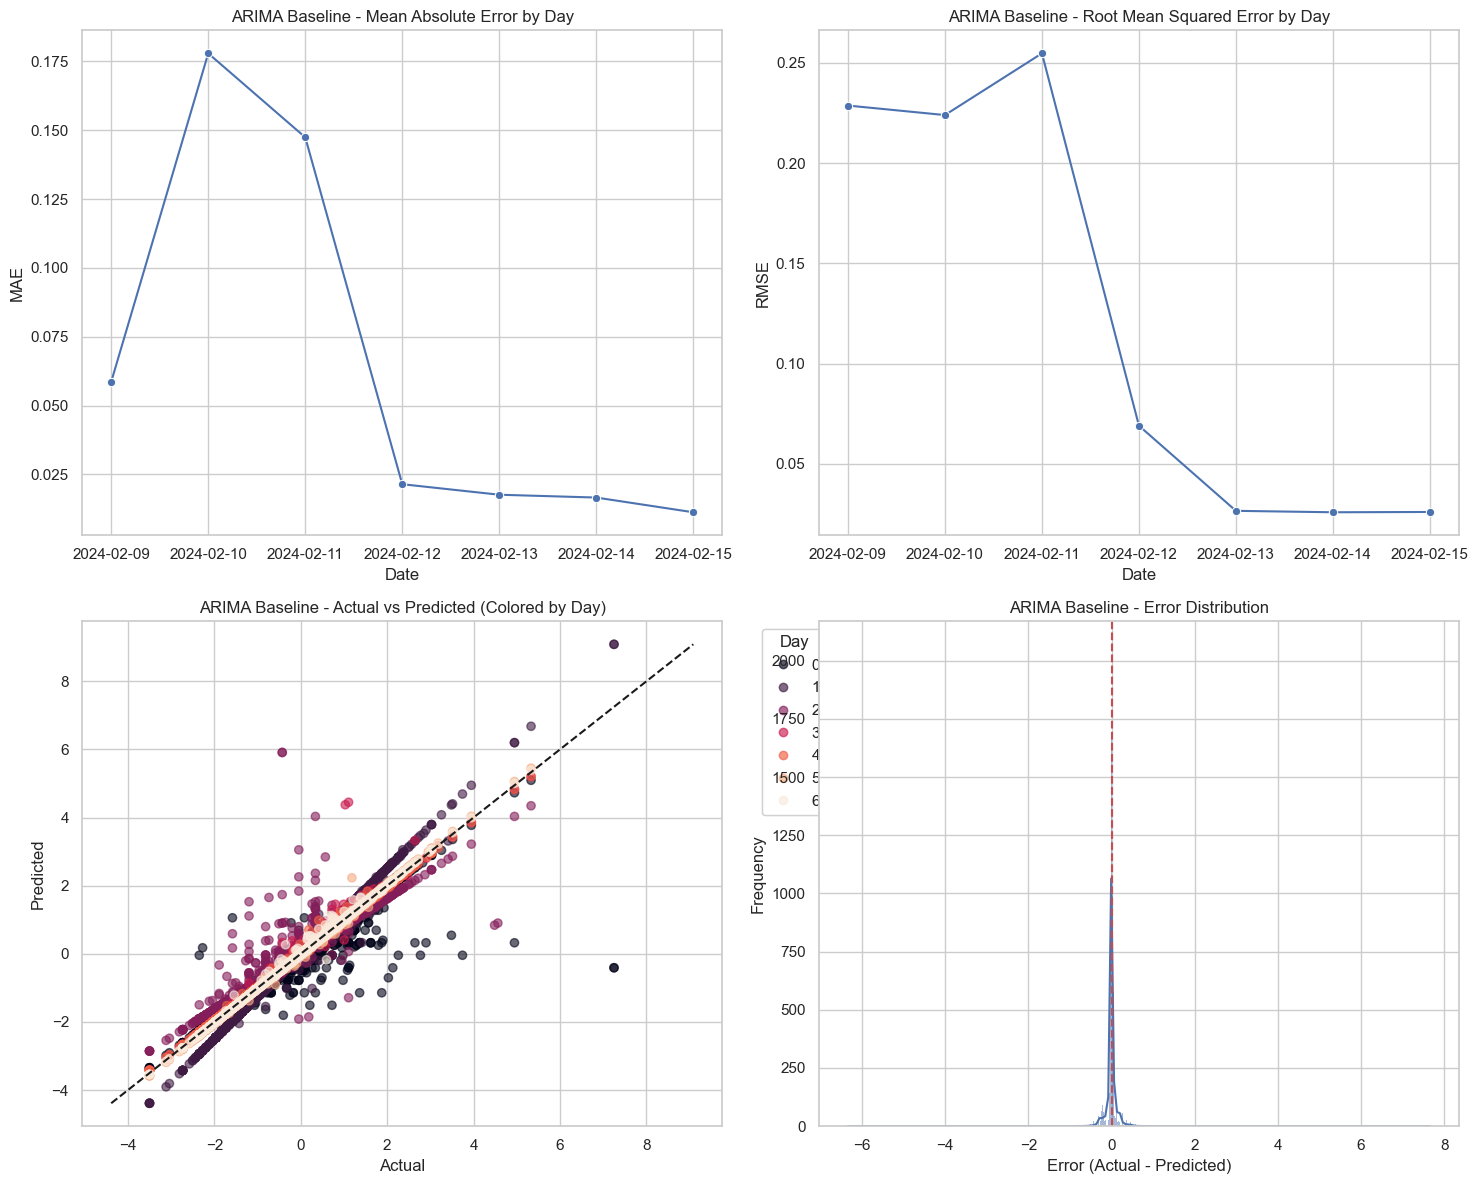

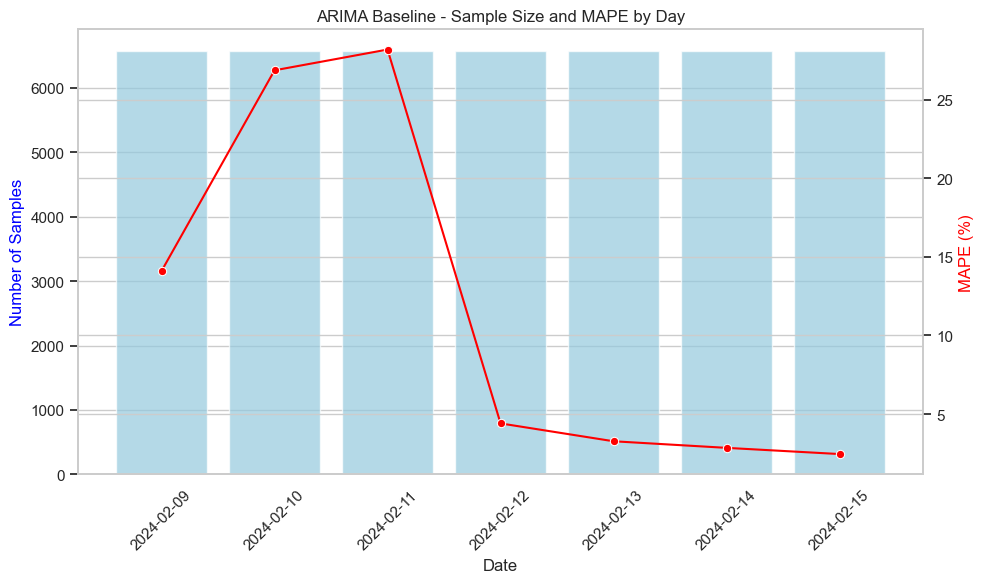

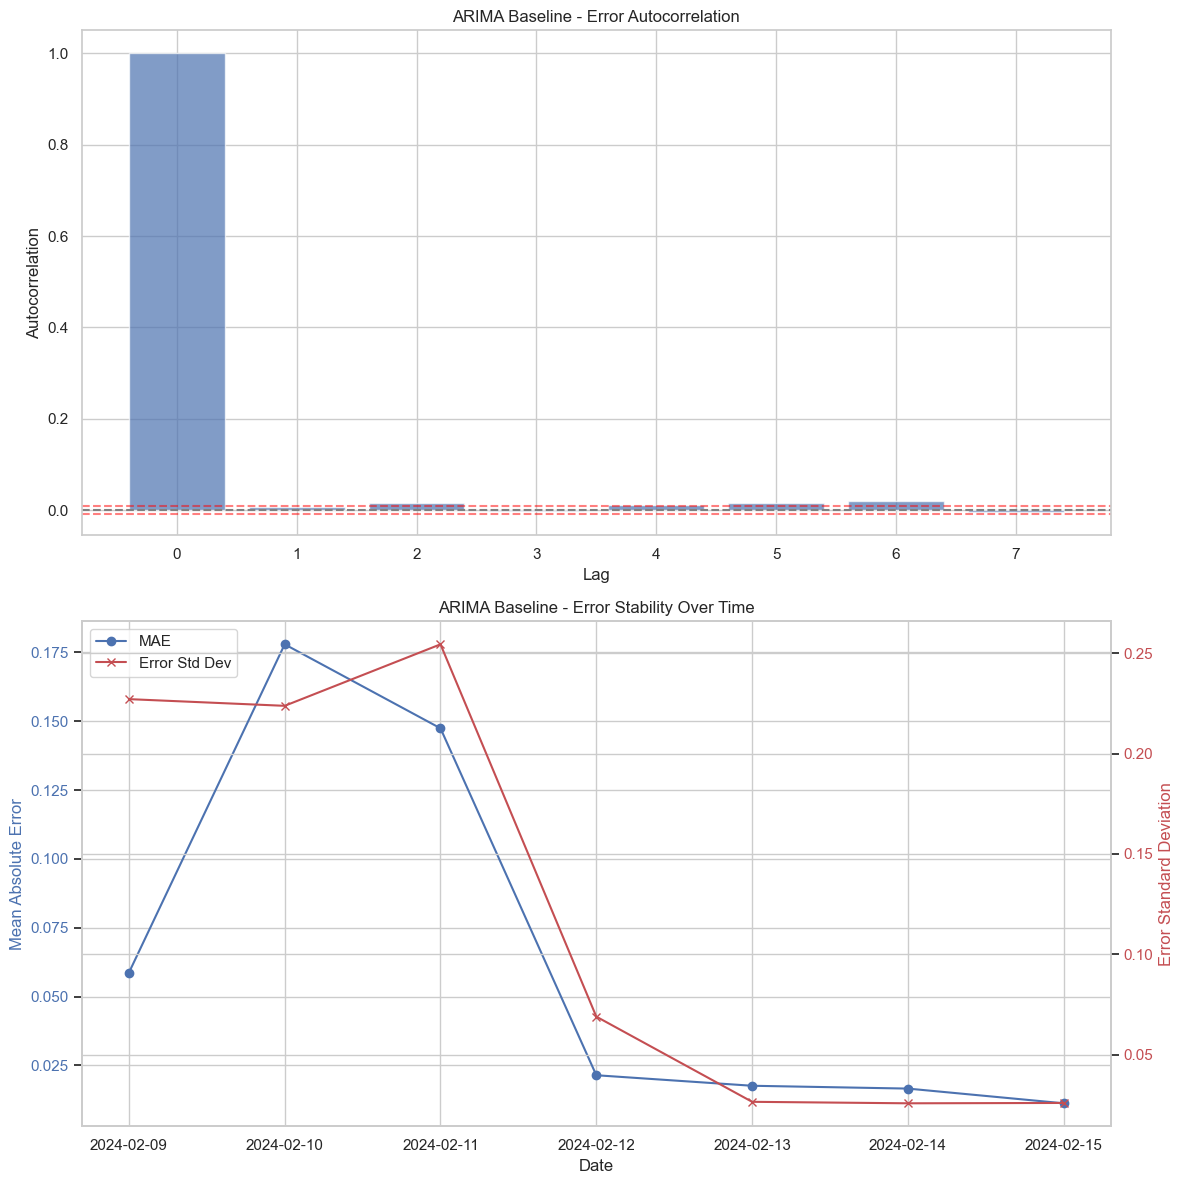

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.stattools import acf
from tqdm import tqdm
import warnings
from datetime import datetime, timedelta
import math

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def calculate_improved_error_autocorrelation(all_results, max_lag=7):
    """
    Calculate error autocorrelation with improved methodology
    
    Parameters:
    -----------
    all_results : DataFrame
        DataFrame containing 'date', 'listing_id', and 'error' columns
    max_lag : int
        Maximum lag to compute
        
    Returns:
    --------
    global_acf : array
        Global autocorrelation of errors
    listing_acfs : dict
        Dictionary of autocorrelation values for each listing with sufficient data
    """
    from statsmodels.tsa.stattools import acf
    import numpy as np
    
    # Sort by date first to ensure chronological order
    all_results = all_results.sort_values(['date', 'listing_id'])
    
    # 1. Calculate global autocorrelation
    global_errors = all_results['error'].values
    try:
        global_acf = acf(global_errors, nlags=max_lag)[1:]  # Exclude lag 0
    except:
        global_acf = np.zeros(max_lag)
    
    # 2. Calculate autocorrelation for each listing
    listing_acfs = {}
    
    # For each listing with enough data points
    for listing_id, group in all_results.groupby('listing_id'):
        if len(group) > max_lag + 2:  # Need enough data points
            listing_errors = group.sort_values('date')['error'].values
            try:
                listing_acfs[listing_id] = acf(listing_errors, nlags=max_lag)[1:]
            except:
                listing_acfs[listing_id] = np.zeros(max_lag)
    
    # 3. Calculate average autocorrelation across listings
    if listing_acfs:
        avg_listing_acf = np.mean([acf_vals for acf_vals in listing_acfs.values()], axis=0)
    else:
        avg_listing_acf = np.zeros(max_lag)
    
    return {
        'global_acf': global_acf,
        'listing_acfs': listing_acfs,
        'avg_listing_acf': avg_listing_acf
    }

def calculate_error_stability(all_results):
    """
    Calculate error stability metrics:
    1. Standard deviation of errors within each day
    2. Consistency of MAE across days
    """
    # Group by date
    grouped = all_results.groupby('date_str')
    
    # Calculate standard deviation of errors for each day
    daily_error_std = grouped['error'].std()
    
    # Calculate MAE for each day
    daily_mae = grouped['abs_error'].mean()
    
    # Calculate stability metrics
    mae_stability = daily_mae.std() / daily_mae.mean()  # Lower is better
    
    return {
        'daily_error_std': daily_error_std,
        'daily_mae': daily_mae,
        'mae_stability_coefficient': mae_stability
    }

def run_day_by_day_arima_baseline(train_path, test_path, arima_order=(1, 1, 1), prediction_days=7):
    """
    Run ARIMA model with day-by-day prediction approach, exactly matching the ST-RAP neural network analysis.
    Uses a single ARIMA model for all listings but updates predictions day by day.
    """
    print(f"Running day-by-day ARIMA prediction with order {arima_order}")
    
    # Load training and test data
    print("Loading data...")
    train_data = pd.read_csv(train_path)
    test_data = pd.read_csv(test_path)
    
    # Convert date columns to datetime
    train_data['date'] = pd.to_datetime(train_data['date'])
    test_data['date'] = pd.to_datetime(test_data['date'])
    
    # Sort by date
    train_data = train_data.sort_values('date')
    test_data = test_data.sort_values('date')
    
    # Get unique dates in test set
    test_dates = test_data['date'].dt.date.unique()
    print(f"Test set contains {len(test_dates)} unique dates.")
    
    # Limit to specified prediction days
    if len(test_dates) > prediction_days:
        test_dates = test_dates[:prediction_days]
        print(f"Limited to first {prediction_days} days for prediction.")
    
    # Initialize results storage
    daily_results = []
    
    # Get global average price from training data (used as fallback)
    global_avg_price = train_data['price'].mean()
    
    # Get the latest known price for each listing
    latest_prices = train_data.sort_values('date').groupby('listing_id').last()['price']
    
    # Process each day in the test set
    for day_idx, day in enumerate(tqdm(test_dates, desc="Processing days")):
        # Get test data for the current day
        day_test = test_data[test_data['date'].dt.date == day]
        
        # Get unique listings for this day
        day_listings = day_test['listing_id'].unique()
        
        # Calculate average price by day in the updated training data
        # This creates a time series of market trends
        daily_avg = train_data.groupby(train_data['date'].dt.date)['price'].mean().reset_index()
        daily_avg.columns = ['date', 'avg_price']
        
        # Fit ARIMA model on the average price time series
        try:
            # Only use ARIMA if we have enough data points
            if len(daily_avg) >= 4:  # Minimum data needed for meaningful ARIMA
                model = ARIMA(daily_avg['avg_price'].values, order=arima_order)
                model_fit = model.fit()
                
                # Forecast next day's average price
                forecast_avg = model_fit.forecast(steps=1)[0]
                
                # Get the most recent average price
                latest_avg = daily_avg['avg_price'].iloc[-1]
                
                # Calculate the market trend multiplier
                trend_multiplier = forecast_avg / latest_avg if latest_avg > 0 else 1.0
            else:
                # Not enough data for ARIMA, use the last day's average
                trend_multiplier = 1.0
        except:
            # If ARIMA fails, assume no trend change
            trend_multiplier = 1.0
            
        # Make predictions for each listing on this day
        day_predictions = []
        
        for listing_id in day_listings:
            # Get actual price from test data
            actual_price = day_test[day_test['listing_id'] == listing_id]['price'].values[0]
            
            # Get listing's most recent price from training data
            if listing_id in latest_prices.index:
                base_price = latest_prices[listing_id]
            else:
                # If we haven't seen this listing before, use global average
                base_price = global_avg_price
            
            # Apply the market trend to get predicted price
            predicted_price = base_price * trend_multiplier
            
            # Add to results
            day_predictions.append({
                'date': day,
                'listing_id': listing_id,
                'actual': actual_price,
                'predicted': predicted_price,
                'abs_error': abs(actual_price - predicted_price),
                'error': actual_price - predicted_price,
                'pct_error': abs((actual_price - predicted_price) / actual_price) * 100 if actual_price > 0 else 0
            })
        
        # Store day's results
        day_results = pd.DataFrame(day_predictions)
        daily_results.append(day_results)
        
        # Update training data with the current day's actual values
        # This simulates getting actual values at the end of each day
        # before predicting the next day - exactly matching your neural network approach
        train_data = pd.concat([train_data, day_test], ignore_index=True)
        
        # Update latest prices with actual prices from this day
        for _, row in day_test.iterrows():
            latest_prices[row['listing_id']] = row['price']
    
    # Combine all daily results
    all_results = pd.concat(daily_results, ignore_index=True)
    
    # Calculate overall metrics
    y_true = all_results['actual'].values
    y_pred = all_results['predicted'].values
    
    metrics = {
        'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
        'mae': mean_absolute_error(y_true, y_pred),
        'r2': r2_score(y_true, y_pred),
        'mape': np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100  # Added small epsilon to avoid division by zero
    }
    
    # Calculate daily metrics
    daily_metrics = []
    for day_df in daily_results:
        day = day_df['date'].iloc[0]
        y_true_day = day_df['actual'].values
        y_pred_day = day_df['predicted'].values
        
        daily_metrics.append({
            'date': day,
            'rmse': np.sqrt(mean_squared_error(y_true_day, y_pred_day)),
            'mae': mean_absolute_error(y_true_day, y_pred_day),
            'r2': r2_score(y_true_day, y_pred_day) if len(set(y_true_day)) > 1 else np.nan,
            'mape': np.mean(np.abs((y_true_day - y_pred_day) / (y_true_day + 1e-8))) * 100,  # Added small epsilon
            'n_samples': len(y_true_day)
        })
    
    daily_metrics_df = pd.DataFrame(daily_metrics)
    
    # Add date_str column for grouping
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')

    # Calculate error autocorrelation
    error_autocorrelation = calculate_error_autocorrelation(all_results['error'].values)

    # Calculate error stability metrics
    error_stability = calculate_error_stability(all_results)
    
    # Create evaluation results dictionary
    evaluation_results = {
        'overall_metrics': metrics,
        'daily_metrics': daily_metrics_df,
        'all_results': all_results,
        'error_autocorrelation': error_autocorrelation,
        'error_stability': error_stability
    }
    
    return evaluation_results

def plot_results(evaluation_results, model_name="ARIMA Baseline"):
    """Plot the results from predictions - matches ST-RAP visualization exactly"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    daily_metrics = evaluation_results['daily_metrics']
    all_results = evaluation_results['all_results']
    
    # Create a figure with multiple subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Daily MAE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['mae'],
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title(f'{model_name} - Mean Absolute Error by Day')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('MAE')
    
    # Plot 2: Daily RMSE
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']),
        y=daily_metrics['rmse'],
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title(f'{model_name} - Root Mean Squared Error by Day')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('RMSE')
    
    # Plot 3: Actual vs Predicted
    all_results['date_str'] = pd.to_datetime(all_results['date']).dt.strftime('%Y-%m-%d')
    scatter = axes[1, 0].scatter(
        all_results['actual'],
        all_results['predicted'],
        c=pd.factorize(all_results['date_str'])[0],
        alpha=0.6
    )
    min_val = min(all_results['actual'].min(), all_results['predicted'].min())
    max_val = max(all_results['actual'].max(), all_results['predicted'].max())
    axes[1, 0].plot([min_val, max_val], [min_val, max_val], 'k--')
    axes[1, 0].set_title(f'{model_name} - Actual vs Predicted (Colored by Day)')
    axes[1, 0].set_xlabel('Actual')
    axes[1, 0].set_ylabel('Predicted')
    
    # Create legend for the scatter plot
    legend1 = axes[1, 0].legend(*scatter.legend_elements(),
                           title="Day", loc="upper left", bbox_to_anchor=(1.05, 1))
    axes[1, 0].add_artist(legend1)
    
    # Plot 4: Error distribution
    all_results['error'] = all_results['actual'] - all_results['predicted']
    sns.histplot(all_results['error'], kde=True, ax=axes[1, 1])
    axes[1, 1].axvline(0, color='r', linestyle='--')
    axes[1, 1].set_title(f'{model_name} - Error Distribution')
    axes[1, 1].set_xlabel('Error (Actual - Predicted)')
    axes[1, 1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Create additional plot for sample size and MAPE
    plt.figure(figsize=(10, 6))
    ax1 = plt.gca()
    ax2 = ax1.twinx()
    
    sns.barplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['n_samples'],
        color='skyblue',
        alpha=0.7,
        ax=ax1
    )
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Samples', color='blue')
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)
    
    sns.lineplot(
        x=pd.to_datetime(daily_metrics['date']).dt.strftime('%Y-%m-%d'),
        y=daily_metrics['mape'],
        marker='o',
        color='red',
        ax=ax2
    )
    ax2.set_ylabel('MAPE (%)', color='red')
    
    plt.title(f'{model_name} - Sample Size and MAPE by Day')
    plt.tight_layout()
    plt.show()

def plot_improved_error_analysis(acf_results, model_name="ARIMA Baseline"):
    """Plot improved error autocorrelation analysis"""
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set up figure
    fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
    # Plot global error autocorrelation
    lags = range(1, len(acf_results['global_acf']) + 1)
    axes[0].bar(lags, acf_results['global_acf'], alpha=0.7)
    axes[0].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals (95%)
    # Assuming N is the total number of observations used for global ACF
    N = len(acf_results['global_acf']) * 10  # Rough approximation
    conf_interval = 1.96 / np.sqrt(N)
    axes[0].axhline(y=conf_interval, linestyle='--', color='red', alpha=0.5)
    axes[0].axhline(y=-conf_interval, linestyle='--', color='red', alpha=0.5)
    
    axes[0].set_xlabel('Lag')
    axes[0].set_ylabel('Autocorrelation')
    axes[0].set_title(f'{model_name} - Global Error Autocorrelation')
    
    # Plot average listing-level autocorrelation
    axes[1].bar(lags, acf_results['avg_listing_acf'], alpha=0.7, color='green')
    axes[1].axhline(y=0, linestyle='--', color='gray')
    
    # Add confidence intervals
    N_avg = len(acf_results['listing_acfs'])  # Number of listings used
    if N_avg > 0:
        conf_interval_avg = 1.96 / np.sqrt(N_avg)
        axes[1].axhline(y=conf_interval_avg, linestyle='--', color='red', alpha=0.5)
        axes[1].axhline(y=-conf_interval_avg, linestyle='--', color='red', alpha=0.5)
    
    axes[1].set_xlabel('Lag')
    axes[1].set_ylabel('Average Autocorrelation')
    axes[1].set_title(f'{model_name} - Average Listing-Level Error Autocorrelation (n={len(acf_results["listing_acfs"])} listings)')
    
    plt.tight_layout()
    plt.show()

def print_summary(evaluation_results, model_name="ARIMA Baseline"):
    """Print a summary of performance - matches ST-RAP summary format"""
    overall = evaluation_results['overall_metrics']
    daily = evaluation_results['daily_metrics']
    error_autocorr = evaluation_results['error_autocorrelation']
    error_stability = evaluation_results['error_stability']
    
    print(f"\n===== {model_name} MODEL EVALUATION =====")
    print("\n=== Overall Metrics ===")
    print(f"RMSE: {overall['rmse']:.4f}")
    print(f"MAE: {overall['mae']:.4f}")
    print(f"R²: {overall['r2']:.4f}")
    print(f"MAPE: {overall['mape']:.4f}%")
    
    print("\n=== Daily Performance ===")
    print(daily[['date', 'rmse', 'mae', 'mape', 'n_samples']].to_string(index=False))
    
    print("\n=== Performance Statistics ===")
    print("MAE:")
    print(f"  Average: {daily['mae'].mean():.4f}")
    print(f"  Min: {daily['mae'].min():.4f} (Day: {daily.loc[daily['mae'].idxmin(), 'date']})")
    print(f"  Max: {daily['mae'].max():.4f} (Day: {daily.loc[daily['mae'].idxmax(), 'date']})")
    
    print("\nRMSE:")
    print(f"  Average: {daily['rmse'].mean():.4f}")
    print(f"  Min: {daily['rmse'].min():.4f} (Day: {daily.loc[daily['rmse'].idxmin(), 'date']})")
    print(f"  Max: {daily['rmse'].max():.4f} (Day: {daily.loc[daily['rmse'].idxmax(), 'date']})")
    
    print("\nMAPE:")
    print(f"  Average: {daily['mape'].mean():.2f}%")
    print(f"  Min: {daily['mape'].min():.2f}% (Day: {daily.loc[daily['mape'].idxmin(), 'date']})")
    print(f"  Max: {daily['mape'].max():.2f}% (Day: {daily.loc[daily['mape'].idxmax(), 'date']})")
    
    print("\n=== Error Autocorrelation ===")
    for lag, acf_value in enumerate(error_autocorr, 1):
        print(f"  Lag {lag}: {acf_value:.4f}")
    
    print("\n=== Error Stability ===")
    print(f"  MAE Stability Coefficient: {error_stability['mae_stability_coefficient']:.4f}")
    print("  (Lower values indicate more consistent predictions across days)")

def compare_models(strap_results, arima_results):
    """Create comparison visualizations between ST-RAP and ARIMA models"""
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Extract data
    strap_daily = strap_results['daily_metrics']
    arima_daily = arima_results['daily_metrics']
    
    # Ensure date is datetime
    strap_daily['date'] = pd.to_datetime(strap_daily['date'])
    arima_daily['date'] = pd.to_datetime(arima_daily['date'])
    
    # Create combined dataframe for metrics
    strap_daily['model'] = 'ST-RAP'
    arima_daily['model'] = 'ARIMA'
    combined_metrics = pd.concat([strap_daily, arima_daily])
    
    # Create comparison visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: MAE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mae', 
        hue='model',
        marker='o',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('MAE Comparison')
    axes[0, 0].set_xlabel('Date')
    axes[0, 0].set_ylabel('Mean Absolute Error')
    
    # Plot 2: RMSE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='rmse', 
        hue='model',
        marker='o',
        ax=axes[0, 1]
    )
    axes[0, 1].set_title('RMSE Comparison')
    axes[0, 1].set_xlabel('Date')
    axes[0, 1].set_ylabel('Root Mean Squared Error')
    
    # Plot 3: MAPE Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='mape', 
        hue='model',
        marker='o',
        ax=axes[1, 0]
    )
    axes[1, 0].set_title('MAPE Comparison')
    axes[1, 0].set_xlabel('Date')
    axes[1, 0].set_ylabel('Mean Absolute Percentage Error (%)')
    
    # Plot 4: R² Comparison
    sns.lineplot(
        data=combined_metrics, 
        x='date', 
        y='r2', 
        hue='model',
        marker='o',
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('R² Comparison')
    axes[1, 1].set_xlabel('Date')
    axes[1, 1].set_ylabel('R² Score')
    
    plt.tight_layout()
    plt.show()
    
    # Create bar chart comparison of overall metrics
    strap_overall = strap_results['overall_metrics']
    arima_overall = arima_results['overall_metrics']
    
    metrics = ['rmse', 'mae', 'mape']
    strap_values = [strap_overall['rmse'], strap_overall['mae'], strap_overall['mape']]
    arima_values = [arima_overall['rmse'], arima_overall['mae'], arima_overall['mape']]
    
    # Set up figure
    plt.figure(figsize=(12, 6))
    
    # Set positions and width
    positions = np.arange(len(metrics))
    width = 0.35
    
    # Create bars
    plt.bar(positions - width/2, strap_values, width, label='ST-RAP')
    plt.bar(positions + width/2, arima_values, width, label='ARIMA')
    
    # Add labels and titles
    plt.ylabel('Value')
    plt.title('Overall Performance Metrics Comparison')
    plt.xticks(positions, ['RMSE', 'MAE', 'MAPE'])
    plt.legend()
    
    # Add value labels on top of bars
    for i, v in enumerate(strap_values):
        plt.text(i - width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    for i, v in enumerate(arima_values):
        plt.text(i + width/2, v + 0.1, f'{v:.2f}', ha='center')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Specify paths to your data
    train_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_cheapest_listings_subset\train.csv"
    test_path = r"C:\Users\matth\OneDrive\Documents\KU Leuven\Thesis\De Ultieme Data\top_cheapest_listings_subset\test_feb.csv"
    
    # Run ARIMA prediction with specified parameters
    arima_order = (1, 1, 1)  # Using standard ARIMA(1,1,1) configuration
    arima_results = run_day_by_day_arima_baseline(
        train_path=train_path,
        test_path=test_path,
        arima_order=arima_order,
        prediction_days=7
    )
    
    # Print summary and plot results
    print_summary(arima_results)
    plot_results(arima_results)
    plot_error_analysis(arima_results)
    
    # If you have STRAP results available, uncomment this code to compare them
    """
    # Assuming you've saved STRAP results or have them available in memory
    # import pickle
    # strap_results = pickle.load(open('strap_results.pkl', 'rb'))
    
    # Or if you have the results directly:
    # strap_results = your_strap_results_variable
    
    # Then compare the models
    compare_models(strap_results, arima_results)
    """